The aim of this toy model is to illustrate the difference between estimating undirected connectivity with partial correlation (based on the zero-lag covariance matrix Q0) and directed connectivity based on time-shifted covariances of the observed activity (Q1 in addition to Q0). It also shows that the mean activity (X) is very similar for all configurations, i.e., hardly informative about the original network parameters.

This provides the basic concepts to understand the paper on connectivity estimation based on the more elaborate gradient descent (Gilson et al., PLoS Comput Biol 2016).

The script generates activity using multivariate Ornstein-Uhelnbeck (MOU) process for 4 network configurations. The 4 networks differ by the connectivity C and the input covariance matrix Sigma (left of the plotted figure; only the diagonal is displayed). The observed activity is also downsampled before calculating the observables: mean activity X and covariance matrices Q0 and Q1 (center of the figure). The network connectivity measures/estimates are located on the right of the figure: Pearson correlations (CORR), partial correlation (PC) and the MVAR and MOU estimates. Compare the estimates with the original network parameters.

Refs:
- Gilson M, Moreno-Bote R, Ponce-Alvarez A, Ritter P, Deco G (2016) Estimation of directed Effective Connectivity from fMRI Functional Connectivity Hints at Asymmetries of Cortical Connectome. PLoS Comput Biol 12: e1004762; doi.org/10.1371/journal.pcbi.1004762
- en.wikipedia.org/wiki/Partial_correlation
- en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process


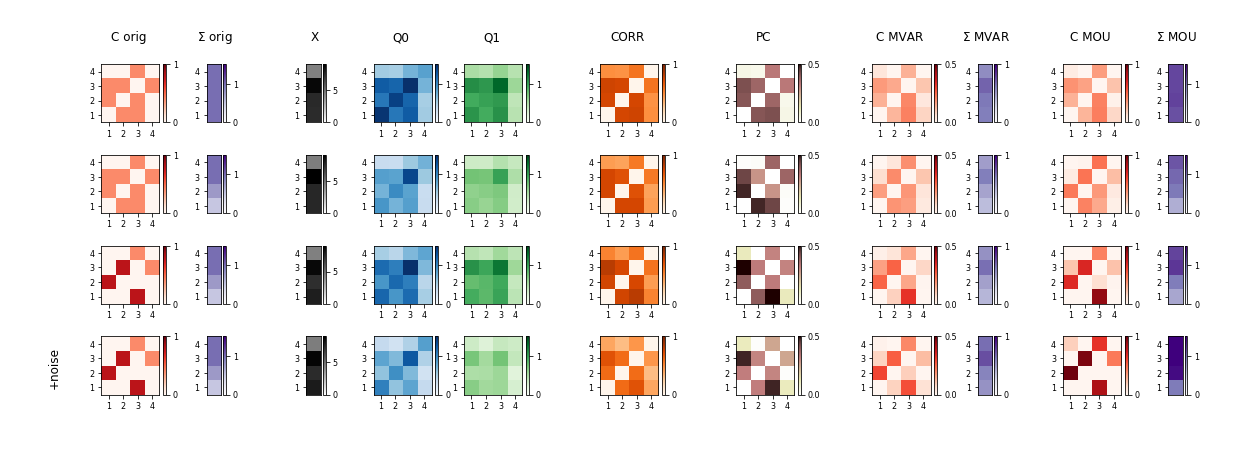

In [10]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as pp


# network and simulation parameters

n_net = 4 # number of network configurations to simulate
N = 4 # number of nodes in network

tau_x = 1. # leakage time constant (common to all nodes)
C = np.zeros([n_net,N,N]) # connectivity matrices
Sigma = np.zeros([n_net,N,N]) # input covariance matrices

mask_diag = np.eye(N,dtype=np.bool) # mask for diagonal elements


T = 1000. # duration of simulation
T0 = 100. # initialization time for network dynamics

dt = 0.05 # temporal resolution for simulation

nT = int(T/dt) # simulation timesteps
nT0 = int(T0/dt) # simulation timesteps to ignore (due to initial condition)
t_span = np.arange(nT0+nT,dtype=np.int) # 

n_sampl = int(1./dt) # sampling to get 1 point every second
nTs = int(T) # number of simulated time points after subsampling


# original network configurations, where C[i,j] is the weight from node j to node i

# 1 C symmetric and Sigma homogeneous
# 2 C symmetric and Sigma heterogeneous
# 3 C directed and Sigma heterogeneous
# 4 same as 3 with non-Gaussian observation noise

# config 3
C[2,1,0] = 1
C[2,2,1] = 1
C[2,0,2] = 1
C[2,3,2] = 0.5
C[2,2,3] = 0.5

# config 1 and 2
C[0,:,:] = 0.5*(C[2,:,:]+C[2,:,:].T)

C[1,:,:] = C[0,:,:]

# config 4
C[3,:,:] = C[2,:,:]

# config 1
Sigma[0,mask_diag] = 1

# config 2, 3 and 4
Sigma[1,:,:] = Sigma[0,:,:]
Sigma[1,1,1] = 0.75
Sigma[1,0,0] = 0.5

Sigma[2,:,:] = Sigma[1,:,:]

Sigma[3,:,:] = Sigma[1,:,:]

# config 4
std_noise = 0.5 # standard deviation for lognormal (non-Gaussian) noise added to config 4
amp_noise = 0.5 # amplitude of noise for config 4

# all configs
C *= 0.8 # homogeneous scaling
I0 = 0.05 # homogeneous inputs


# plot parameters

h_offset = 0.06
v_offset = 0.725

xh = [0, 1, 2.1, 3, 4, 5.5, 7, 8.5, 9.5, 10.6, 11.6]

nh = 11
nv = 4
lv = 0.21
lh = lv*nv/nh

coef_ax = 0.8
coef_ax2 = coef_ax*0.8
dv2 = lv*0.08

v_fig = 6
h_fig = v_fig*nh/nv


# figure
pp.figure(figsize=[h_fig,v_fig])
ax = pp.axes([0,0,1,1])
ax.axis('off')

pp.text(h_offset+xh[0]*lh+lh*0.3,0.93,'C orig',ha='center',fontsize=12)
pp.text(h_offset+xh[1]*lh+lh*0.25,0.93,'$\Sigma$ orig',ha='center',fontsize=12)
pp.text(h_offset+xh[2]*lh+lh*0.25,0.93,'X',ha='center',fontsize=12)
pp.text(h_offset+xh[3]*lh+lh*0.3,0.93,'Q0',ha='center',fontsize=12)
pp.text(h_offset+xh[4]*lh+lh*0.3,0.93,'Q1',ha='center',fontsize=12)
pp.text(h_offset+xh[5]*lh+lh*0.3,0.93,'CORR',ha='center',fontsize=12)
pp.text(h_offset+xh[6]*lh+lh*0.3,0.93,'PC',ha='center',fontsize=12)
pp.text(h_offset+xh[7]*lh+lh*0.3,0.93,'C MVAR',ha='center',fontsize=12)
pp.text(h_offset+xh[8]*lh+lh*0.25,0.93,'$\Sigma$ MVAR',ha='center',fontsize=12)
pp.text(h_offset+xh[9]*lh+lh*0.3,0.93,'C MOU',ha='center',fontsize=12)
pp.text(h_offset+xh[10]*lh+lh*0.25,0.93,'$\Sigma$ MOU',ha='center',fontsize=12)

pp.text(0.02,0.2,'+noise',ha='center',rotation=90,fontsize=12)

# simulation for 4 configurations
for i_net in range(n_net):
    
    # simulated Jacobian
    J_sim = -np.eye(N)/tau_x + C[i_net,:,:]
    # simulated input noise
    Sigma_sim = Sigma[i_net,:,:]
    # multivariate Ornstein-Uhlenbeck simulation
    ts_X = np.zeros([nT,N]) # time series
    v_noise = np.random.normal(size=[nT0+nT,N],scale=(dt**0.5)) # input noise
    X_tmp = np.zeros(N) # initial condition
    for iT in range(nT0+nT):
        X_tmp += dt*np.dot(J_sim,X_tmp) + I0 + np.dot(np.sqrt(Sigma_sim),v_noise[iT,:])
        if iT>nT0:
            ts_X[iT-nT0,:] = X_tmp

    # subsampling
    ts_X = ts_X[::n_sampl,:]
        
    # non-gaussian noise for config 4
    if i_net==n_net-1:
        ts_X += amp_noise*(np.random.lognormal(0,std_noise,size=[int(T),N])-1)

    # mean calculation and demeaning
    X = ts_X.mean(0)
    ts_X -= np.outer(np.ones([nTs]),X)
    #print(ts_X.mean(0))

    # empirical covariances
    Q0 = np.tensordot(ts_X[0:nTs-1,:],ts_X[0:nTs-1,:],axes=(0,0)) / (nTs-2)
    Q1 = np.tensordot(ts_X[0:nTs-1,:],ts_X[1:nTs,:],axes=(0,0)) / (nTs-2)

    # Pearson correlations
    K = np.array(Q0)
    K /= np.sqrt(np.outer(K.diagonal(),K.diagonal()))
    K[mask_diag] = 0
        
    # partial correlation
    P = np.linalg.pinv(Q0)
    P /= -np.sqrt(np.outer(P.diagonal(),P.diagonal()))
    P[mask_diag] = 0

    # MVAR estimate
    A_MVAR = np.dot(np.linalg.pinv(Q0),Q1).T
    C_MVAR = np.array(A_MVAR)
    C_MVAR[mask_diag] = 0
    Sigma_MVAR = Q0 - np.dot(A_MVAR,np.dot(Q0,A_MVAR.T))

    # theoretical MOU estimate
    J_MOU = np.real(spl.logm(np.dot(np.linalg.pinv(Q0),Q1)).T)
    C_MOU = np.array(J_MOU)
    C_MOU[mask_diag] = 0
    Sigma_MOU = - np.dot(J_MOU,Q0) - np.dot(Q0,J_MOU.T)


    # plots
    pp.axes([h_offset+xh[0]*lh,v_offset-i_net*lv,lh*coef_ax,lv*coef_ax])
    pp.imshow(C[i_net,:,:],origin='bottom',interpolation='nearest',vmin=0,vmax=1,cmap='Reds')
    cb = pp.colorbar(ticks=[0,1],shrink=0.8)
    cb.ax.tick_params(labelsize=8)
    pp.xticks(np.arange(N),np.arange(N)+1,fontsize=8)
    pp.yticks(np.arange(N),np.arange(N)+1,fontsize=8)

    pp.axes([h_offset+xh[1]*lh,v_offset-i_net*lv+dv2,lh*coef_ax*0.5,lv*coef_ax2])
    pp.imshow(Sigma[i_net,:,:].diagonal().reshape([N,1]),origin='bottom',interpolation='nearest',vmin=0,vmax=1.5,cmap='Purples')
    cb = pp.colorbar(ticks=[0,1],shrink=1)
    cb.ax.tick_params(labelsize=8)
    pp.xticks([],fontsize=8)
    pp.yticks(np.arange(N),np.arange(N)+1,fontsize=8)
    

    pp.axes([h_offset+xh[2]*lh,v_offset-i_net*lv+dv2,lh*coef_ax*0.5,lv*coef_ax2])
    pp.imshow(X.reshape([N,1]),origin='bottom',interpolation='nearest',vmin=0,vmax=9,cmap='binary')
    cb = pp.colorbar(ticks=[0,5],shrink=1)
    cb.ax.tick_params(labelsize=8)
    pp.xticks([],fontsize=8)
    pp.yticks(np.arange(N),np.arange(N)+1,fontsize=8)

    pp.axes([h_offset+xh[3]*lh,v_offset-i_net*lv,lh*coef_ax,lv*coef_ax])
    pp.imshow(Q0,origin='bottom',interpolation='nearest',vmin=0,vmax=1.5,cmap='Blues')
    cb = pp.colorbar(ticks=[0,1],shrink=0.8)
    cb.ax.tick_params(labelsize=8)
    pp.xticks(np.arange(N),np.arange(N)+1,fontsize=8)
    pp.yticks(np.arange(N),np.arange(N)+1,fontsize=8)

    pp.axes([h_offset+xh[4]*lh,v_offset-i_net*lv,lh*coef_ax,lv*coef_ax])
    pp.imshow(Q1,origin='bottom',interpolation='nearest',vmin=0,vmax=1.5,cmap='Greens')
    cb = pp.colorbar(ticks=[0,1],shrink=0.8)
    cb.ax.tick_params(labelsize=8)
    pp.xticks(np.arange(N),np.arange(N)+1,fontsize=8)
    pp.yticks(np.arange(N),np.arange(N)+1,fontsize=8)


    pp.axes([h_offset+xh[5]*lh,v_offset-i_net*lv,lh*coef_ax,lv*coef_ax])
    pp.imshow(K,origin='bottom',interpolation='nearest',vmin=0,vmax=1,cmap='Oranges')
    cb = pp.colorbar(ticks=[0,1],shrink=0.8)
    cb.ax.tick_params(labelsize=8)
    pp.xticks(np.arange(N),np.arange(N)+1,fontsize=8)
    pp.yticks(np.arange(N),np.arange(N)+1,fontsize=8)


    pp.axes([h_offset+xh[6]*lh,v_offset-i_net*lv,lh*coef_ax,lv*coef_ax])
    pp.imshow(P,origin='bottom',interpolation='nearest',vmin=0,vmax=0.5,cmap='pink_r')
    cb = pp.colorbar(ticks=[0,0.5],shrink=0.8)
    cb.ax.tick_params(labelsize=8)
    pp.xticks(np.arange(N),np.arange(N)+1,fontsize=8)
    pp.yticks(np.arange(N),np.arange(N)+1,fontsize=8)


    pp.axes([h_offset+xh[7]*lh,v_offset-i_net*lv,lh*coef_ax,lv*coef_ax])
    pp.imshow(C_MVAR,origin='bottom',interpolation='nearest',vmin=0,vmax=0.5,cmap='Reds')
    cb = pp.colorbar(ticks=[0,0.5],shrink=0.8)
    cb.ax.tick_params(labelsize=8)
    pp.xticks(np.arange(N),np.arange(N)+1,fontsize=8)
    pp.yticks(np.arange(N),np.arange(N)+1,fontsize=8)
    
    pp.axes([h_offset+xh[8]*lh,v_offset-i_net*lv+dv2,lh*coef_ax*0.5,lv*coef_ax2])
    pp.imshow(Sigma_MVAR.diagonal().reshape([N,1]),origin='bottom',interpolation='nearest',vmin=0,vmax=1,cmap='Purples')
    cb = pp.colorbar(ticks=[0,1],shrink=1)
    cb.ax.tick_params(labelsize=8)
    pp.xticks([],fontsize=8)
    pp.yticks(np.arange(N),np.arange(N)+1,fontsize=8)

    
    pp.axes([h_offset+xh[9]*lh,v_offset-i_net*lv,lh*coef_ax,lv*coef_ax])
    pp.imshow(C_MOU,origin='bottom',interpolation='nearest',vmin=0,vmax=1,cmap='Reds')
    cb = pp.colorbar(ticks=[0,1],shrink=0.8)
    cb.ax.tick_params(labelsize=8)
    pp.xticks(np.arange(N),np.arange(N)+1,fontsize=8)
    pp.yticks(np.arange(N),np.arange(N)+1,fontsize=8)
    
    pp.axes([h_offset+xh[10]*lh,v_offset-i_net*lv+dv2,lh*coef_ax*0.5,lv*coef_ax2])
    pp.imshow(Sigma_MOU.diagonal().reshape([N,1]),origin='bottom',interpolation='nearest',vmin=0,vmax=1.5,cmap='Purples')
    cb = pp.colorbar(ticks=[0,1],shrink=1)
    cb.ax.tick_params(labelsize=8)
    pp.xticks([],fontsize=8)
    pp.yticks(np.arange(N),np.arange(N)+1,fontsize=8)

    
pp.savefig('fig_est_th')
pp.show()